# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',delimiter=';')

# Load in the customer data
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

In [3]:
# checking the number of rows and columns
print(azdias.shape)

(891221, 85)


The general population data set loaded with the expected number of rows and columns.

In [4]:
# checking the number of rows and columns
print(feat_info.shape)

(85, 4)


The feature info data set loaded with the expected number of rows and columns.

In [5]:
# checking the number of rows and colums
print(customers.shape)

(191652, 85)


The customer data set loaded with the expected number of rows and columns.

In [6]:
#view the first five rows of data
azdias.head(5)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


Because this data set has so many columns, I decided not to print the first five rows as it was confusing to look at and instead, am simply viewing the data and using the scroll bar at the bottom.

In [7]:
#print the first 5 rows of data
print(feat_info.head())

              attribute information_level         type missing_or_unknown
0              AGER_TYP            person  categorical             [-1,0]
1  ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2             ANREDE_KZ            person  categorical             [-1,0]
3         CJT_GESAMTTYP            person  categorical                [0]
4     FINANZ_MINIMALIST            person      ordinal               [-1]


With only four columns, it's not a problem to print the first five rows of data.

In [8]:
# view the first 5 rows of data
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [9]:
# make a copy of the azdias and feat_info dataframes before I start changing data
azdias_copy = azdias
feat_info_copy = feat_info
customers_copy = customers

In [10]:
# strip brackets and split values from feat_info_copy data set and replace with NaN as required
for indx in range(len(feat_info_copy)):

    missing_or_unknown_new = feat_info_copy.iloc[indx]['missing_or_unknown']

    missing_or_unknown_new = missing_or_unknown_new.strip('[ ]')

    missing_or_unknown_new = missing_or_unknown_new.split(sep=',')

    missing_or_unknown_new = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_or_unknown_new]

    if missing_or_unknown_new != ['']:

        azdias_copy = azdias_copy.replace({feat_info_copy.iloc[indx]['attribute']: missing_or_unknown_new}, np.nan)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

<Container object of 85 artists>

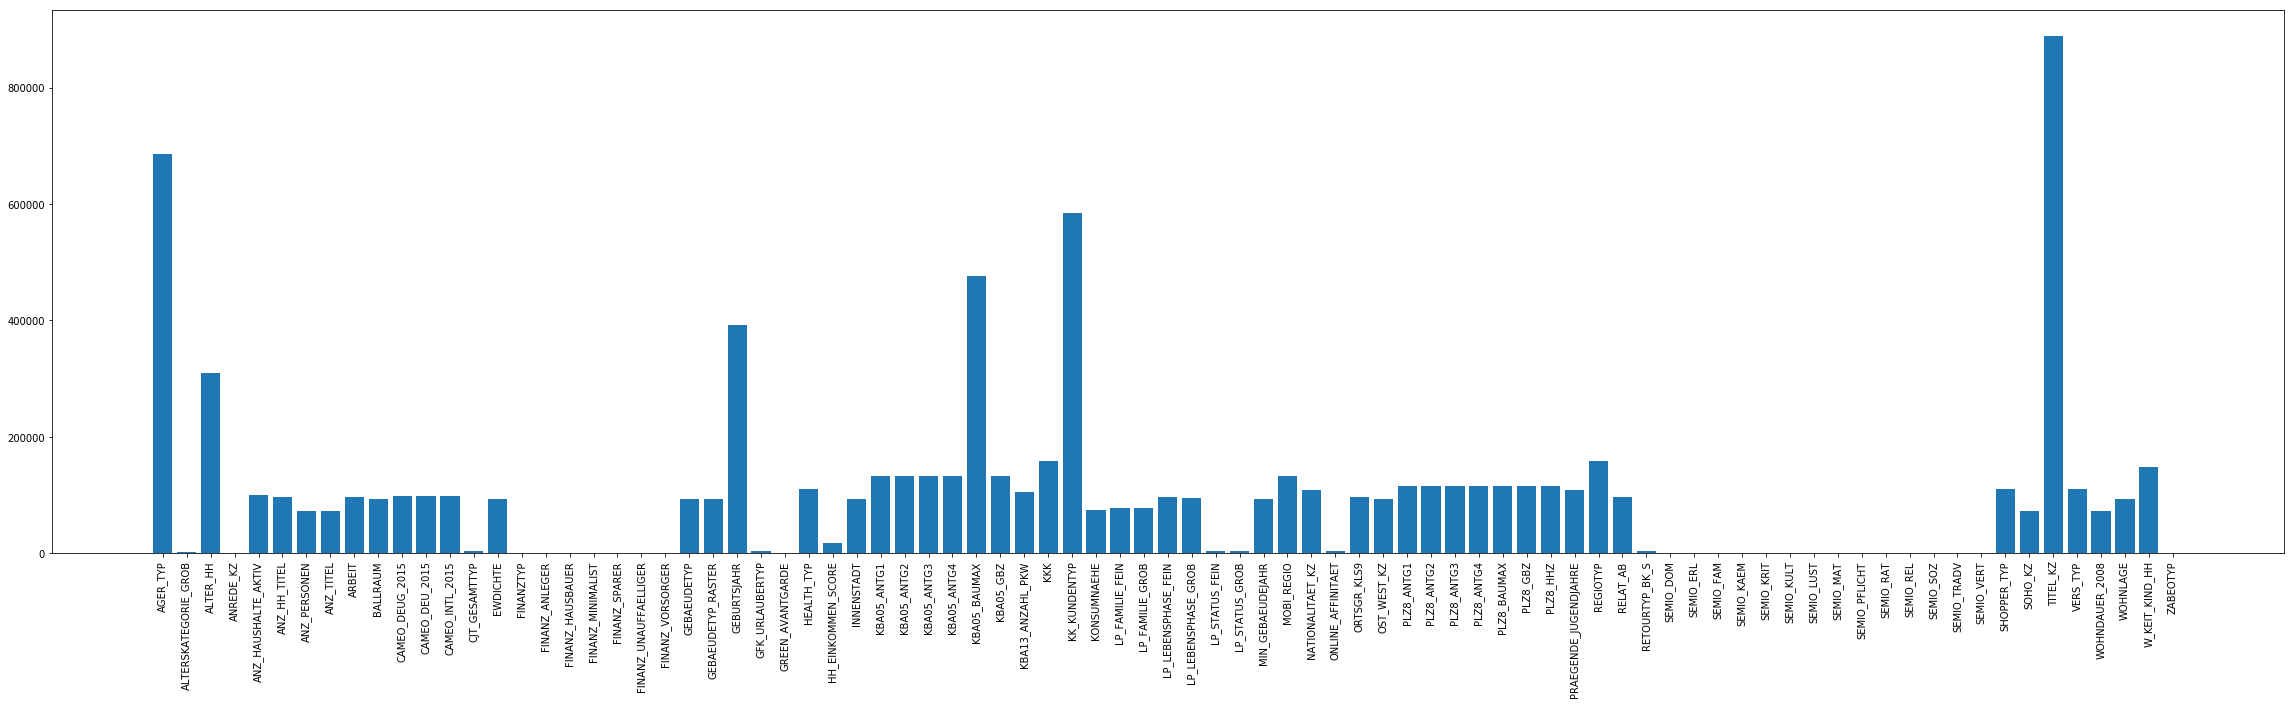

In [11]:
# plot histogram of all missing values in azdias_copy data set and get print out of info as well
missing_values= azdias_copy.isnull().sum().to_frame()
plt.figure(figsize= (40,10))
#print(missing_values)
nan_data=missing_values.values.reshape(missing_values.shape[0]).tolist()
labels=missing_values.index.to_series()
plt.xticks(rotation=90)
plt.bar(labels,nan_data)

In [12]:
# drop the outlier columns from azdias_copy data set
azdias_copy = azdias_copy.drop(['AGER_TYP', 'ALTER_HH','GEBURTSJAHR','KBA05_BAUMAX','KK_KUNDENTYP','TITEL_KZ'], axis = 1)
azdias_copy.head()
# column count shows that 6 columns were dropped

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


### Discussion 1.1.2: Assess Missing Data in Each Column

##### Outliers:

The histogram shows that the following columns have the most missing values:

AGER_TYP

ALTER_HH

GEBURTSJAHR

KBA05_BAUMAX

KK_KUNDENTYP

TITEL_KZ

These are outliers and not necessary to keep in the data set for purposes of this project, so they were removed.

##### Patterns:

##### Several columns had precisely the same amount of missing data:

###### Missing 133324:

KBA05_ANTG1

KBA05_ANTG2

KBA05_ANTG3

KBA05_ANTG4


###### Missing 116515:

PLZ8_ANTG1

PLZ8_ANTG2

PLZ8_ANTG3

PLZ8_ANTG4

PLZ8_BAUMAX

PLZ8_HHZ

PLZ8_GBZ


##### These columns have no missing data at all:

FINANZ_MINIMALIST           

FINANZ_SPARER               

FINANZ_VORSORGER            

FINANZ_ANLEGER              

FINANZ_UNAUFFAELLIGER       

FINANZ_HAUSBAUER            

FINANZTYP

SEMIO_SOZ

SEMIO_FAM

SEMIO_REL

SEMIO_MAT

SEMIO_VERT

SEMIO_LUST


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

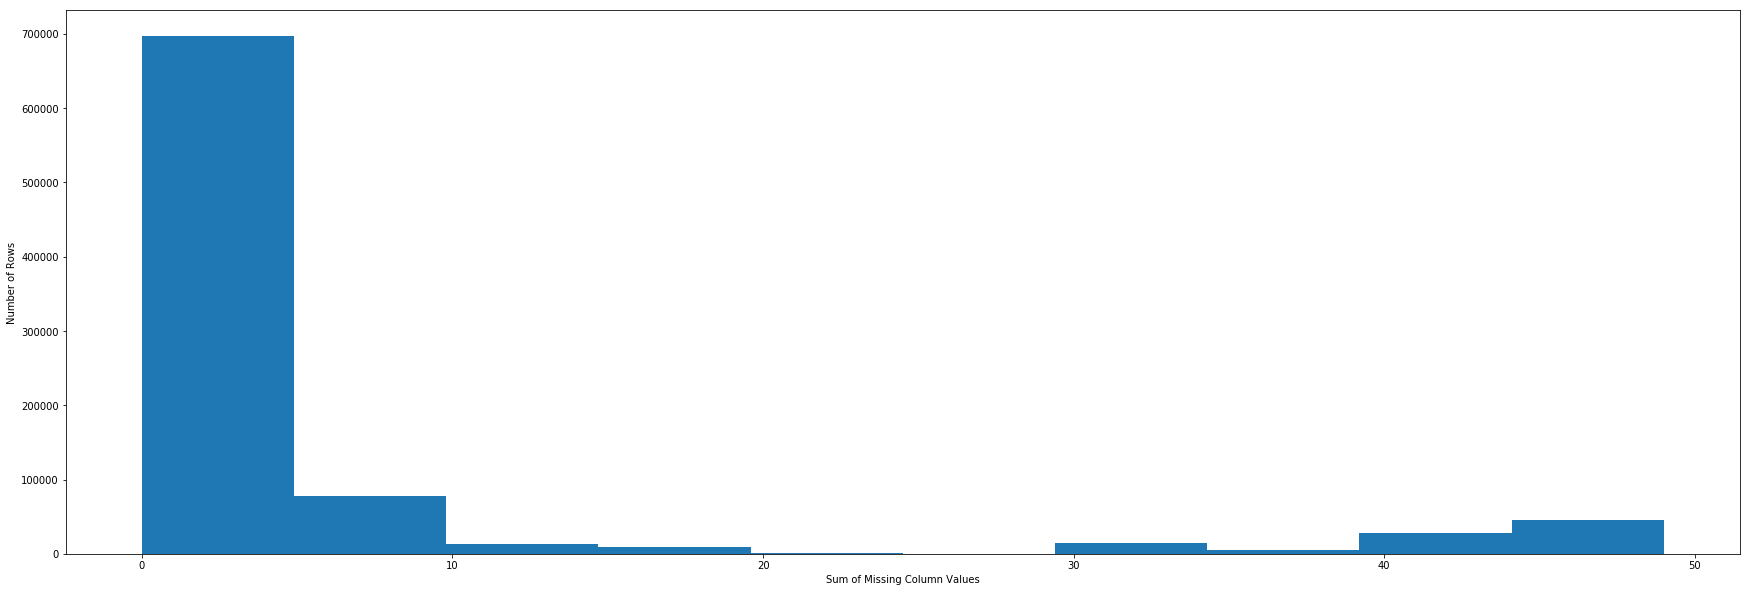

In [13]:
# How much data is missing in each row of the dataset?
nan_rows = azdias_copy.isnull().sum(axis=1)
plt.figure(figsize= (30,10))

plt.hist(nan_rows)
plt.ylabel('Number of Rows')
plt.xlabel('Sum of Missing Column Values')
plt.show()

The graph above shows that approximately 700,000 rows are missing data in 0-5 columns. About 75,000 rows are missing data in 5-10 columns and approximately 35,000 rows are missing data in more than 40 columns. It looks like the best place to split the data is at the 10 column mark. The majority of the rows are represented by the area to the left of that number and splitting it there would remove the outliers.

In [14]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

rows_less_than_10 = azdias_copy[azdias_copy.isnull().sum(axis=1) <= 10]

rows_more_than_10 = azdias_copy[azdias_copy.isnull().sum(axis=1) > 10]

In [15]:
# check the number of rows
type(rows_less_than_10)

pandas.core.frame.DataFrame

In [16]:
# check the number of rows
rows_more_than_10.shape

(111068, 79)

IndexError: index 5 is out of bounds for axis 0 with size 5

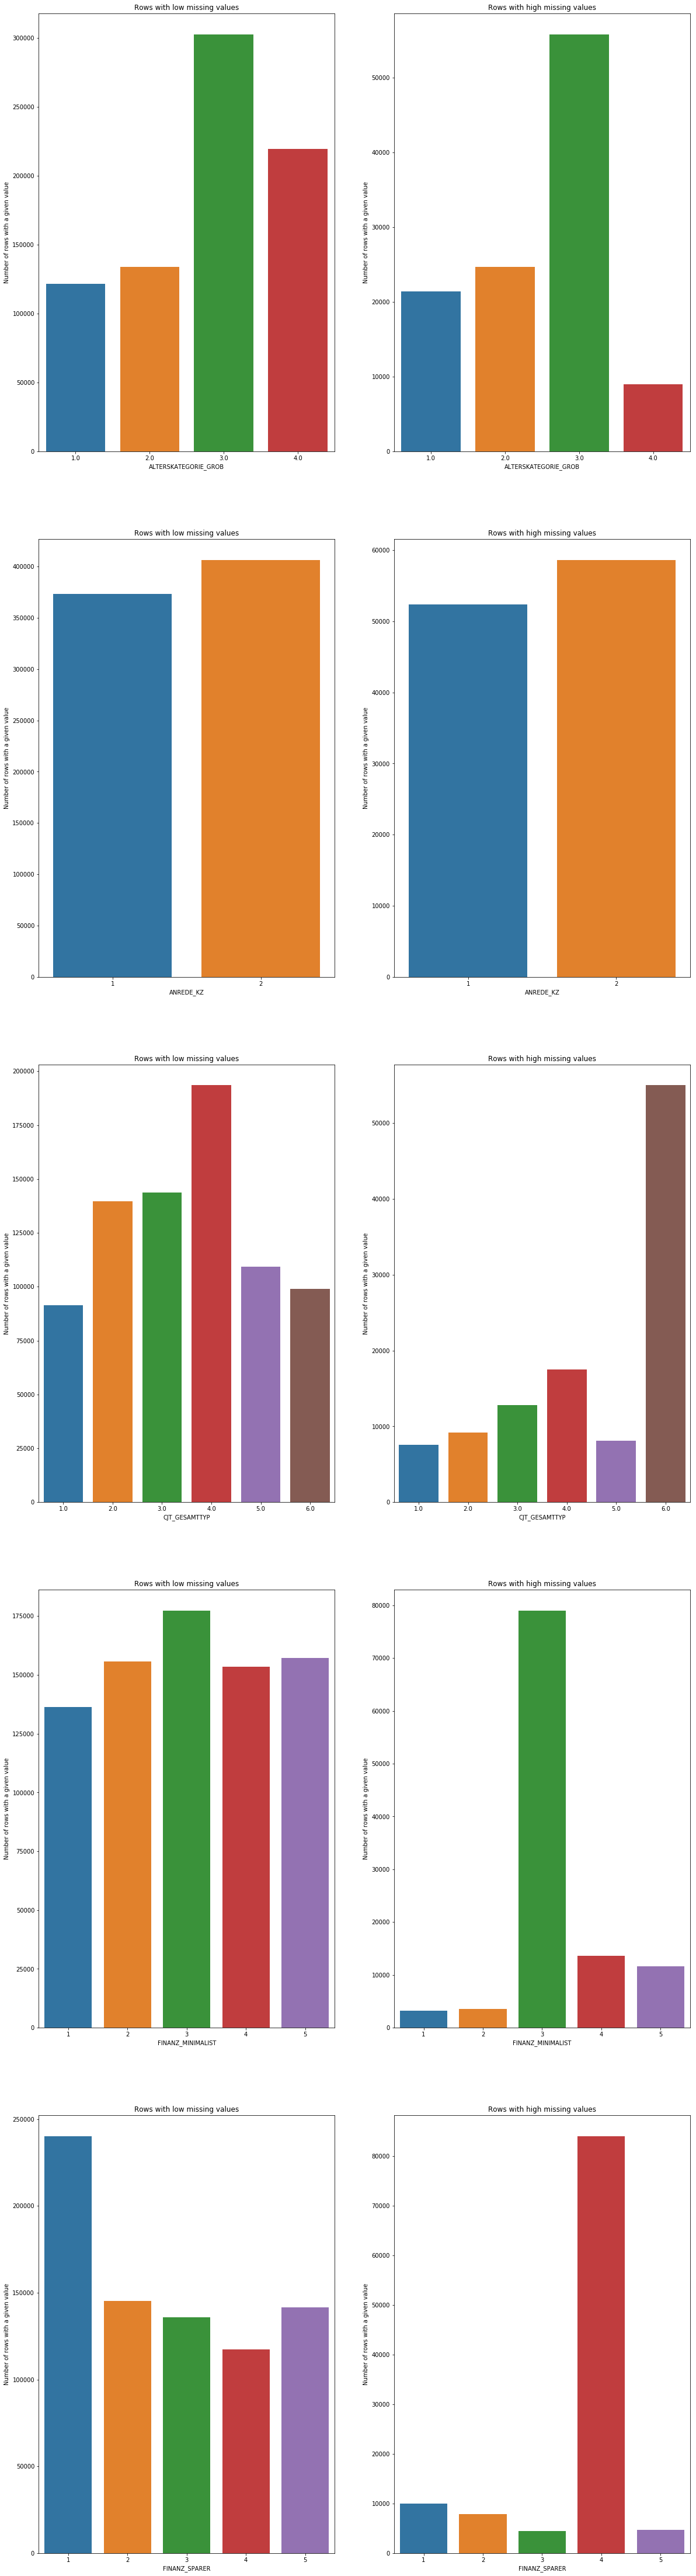

In [17]:
#original code
n=0
fig, axs = plt.subplots(nrows=5,ncols=2,figsize=(20,80))
missing_values = rows_less_than_10.isnull().sum().to_frame()
columns=missing_values.index.to_series()
for column in columns:
    sns.countplot(rows_less_than_10.loc[:,column], ax=axs[n,0])
    axs[n,0].set_ylabel('Number of rows with a given value')
    axs[n,0].set_title('Rows with low missing values')
    sns.countplot(rows_more_than_10.loc[:,column], ax=axs[n,1])
    axs[n,1].set_ylabel('Number of rows with a given value')
    axs[n,1].set_title('Rows with high missing values')
    n+=1

In [ ]:
#subplots with adjusted ax
n=0
fig, ax = plt.subplots(nrows=5,ncols=2,figsize=(20,80))
missing_values = rows_less_than_10.isnull().sum().to_frame()
columns=missing_values.index.to_series()
for column in columns:
    sns.countplot(rows_less_than_10.loc[:,column], ax=ax[0])
    ylabel=('Number of rows with a given value')
    title=('Rows with low missing values')
    sns.countplot(rows_more_than_10.loc[:,column], ax=ax[1])
    ax[n,1].set_ylabel('Number of rows with a given value')
    ax[n,1].set_title('Rows with high missing values')
    n+=1

AttributeError: 'numpy.ndarray' object has no attribute 'bar'

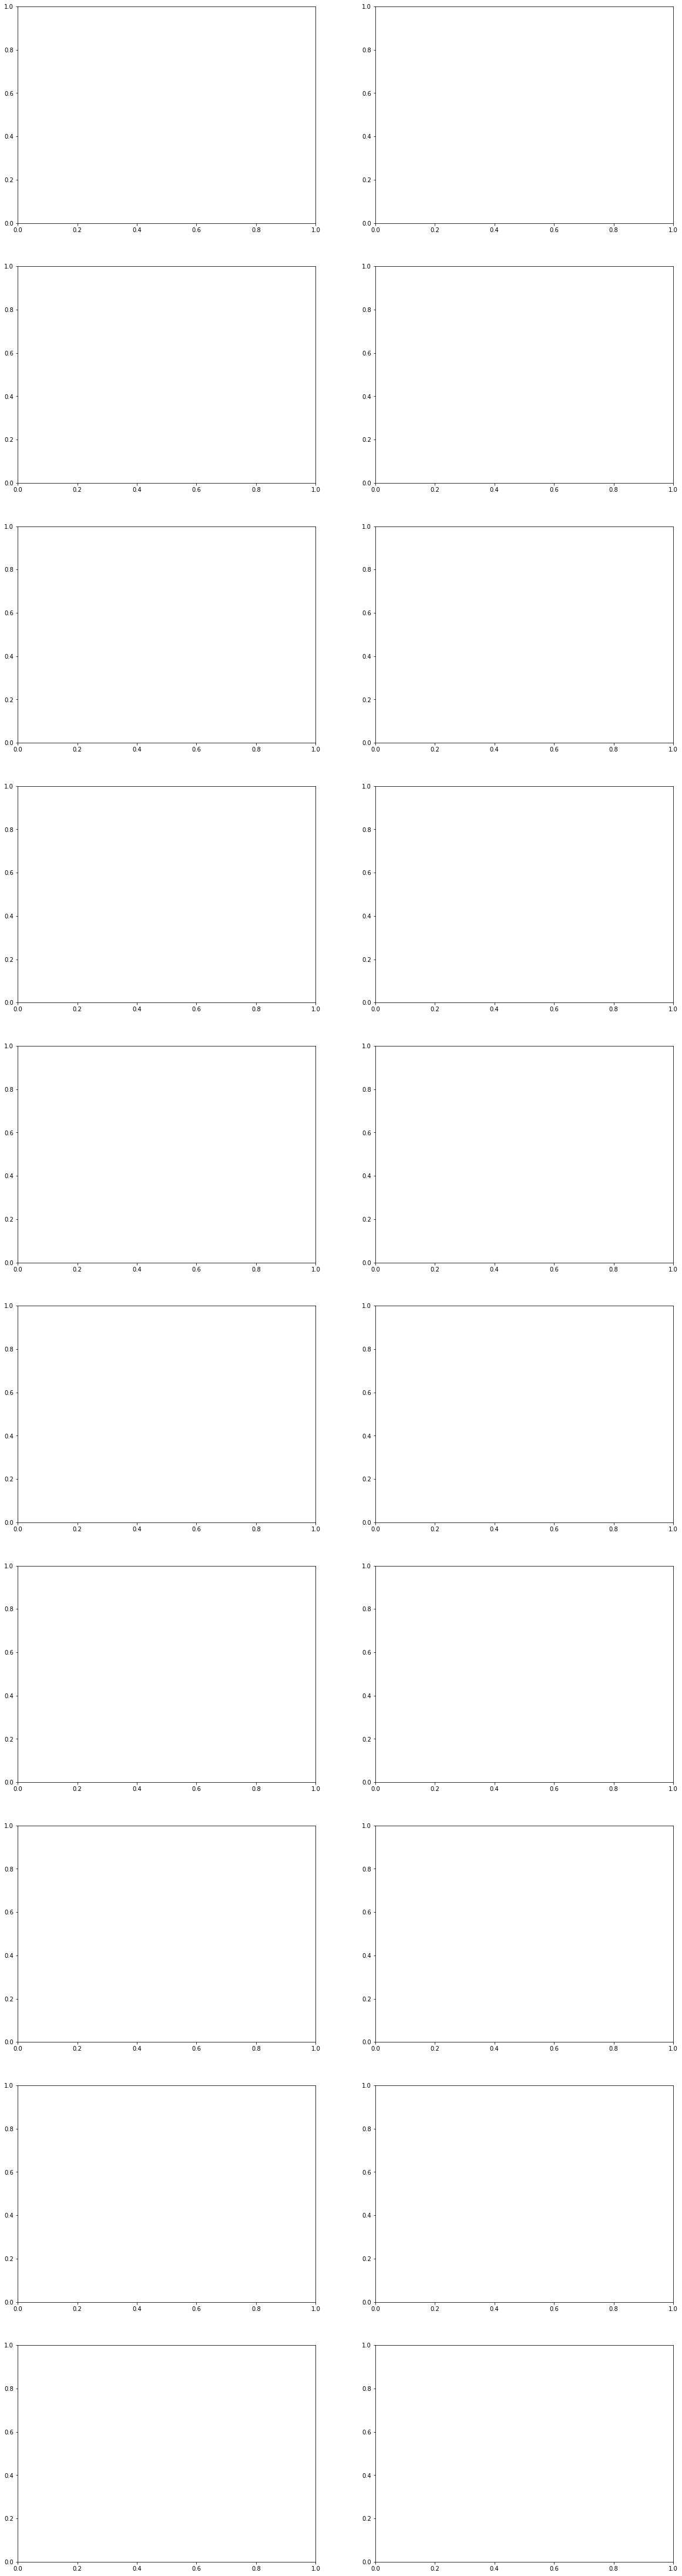

In [18]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
n=0
fig, ax = plt.subplots(nrows = 10,ncols = 2, figsize=(20,80))
missing_values= rows_less_than_10.isnull().sum().to_frame()
columns=missing_values.index.to_series()
for column in columns: 
    sns.countplot(rows_less_than_10[column],ax=ax[0])
    set_ylabel('Number of Rows with a Given Value')
    set_title('Rows with Low Missing Values')
    sns.countplot(rows_more_than_10.loc[:, column], axs=ax[1])
    ax[n,1].set_ylabel('Number of Rows with a Given Value')
    ax[n,1].set_title('Rows with High Missing Values')
    n+=1

#### Discussion 1.1.3: Assess Missing Data in Each Row

For all but one of the 10 columns reviewed, the distribution of values varied significantly between the low missing values group and the high missing values group.

ANREDE_KZ shows very similar value distributions between the two groups. ALTERSKATEGORIE_GROB had the next closest value distribution between the two groups but all other columns had dramatically different value distributions.ues?)

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [19]:
# How many features are there of each data type?
feat_info_copy['type'].value_counts()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [20]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
cat_features = feat_info_copy[feat_info_copy["type"]=="categorical"]["attribute"]
cat_features
#note that three columns have already been removed from azdias_copy (AGER_TYP, TITEL_KZ, KK_KUNDENTYP) and will not be evaluated

0             AGER_TYP
2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
40            TITEL_KZ
41            VERS_TYP
42            ZABEOTYP
47        KK_KUNDENTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object

In [21]:
# for each cat_features entry, determine if it's binary or multilevel and place column name into distinct list
multilevel = []
binary = []

for cat in cat_features:
    if cat in azdias_copy.columns:
        if azdias_copy[cat].nunique()>2:
            multilevel.append(cat)
        elif azdias_copy[cat].nunique()==2:
            binary.append(cat)
        else: 
            continue    

In [22]:
print(multilevel)

['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [23]:
print(binary)
#per data dictionary OST_WEST_KZ has non-numerical values and must be re-encoded

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']


In [24]:
# OST_WEST_KZ is binary but has non-numerical values, so re-encoding to numerical values
ost_west_dict = {'O':1, 'W':2}
azdias_copy['OST_WEST_KZ'].replace(ost_west_dict, inplace=True)

In [25]:
# Decided to remove the multilevel catergorical values rather than re-encode them
azdias_copy = azdias_copy.drop(['CJT_GESAMTTYP', 'FINANZTYP','GFK_URLAUBERTYP','LP_FAMILIE_FEIN','LP_FAMILIE_GROB','LP_STATUS_FEIN',
                  'LP_STATUS_GROB','NATIONALITAET_KZ','SHOPPER_TYP','ZABEOTYP','GEBAEUDETYP','CAMEO_DEUG_2015',
                  'CAMEO_DEU_2015'], axis = 1)

#### Discussion 1.2.1: Re-Encode Categorical Features
Ordinal features make up the majority of the data types in this data set. 

Of the categorical features, there were 21 columns of this data type when reviewing the feat_info_copy data set but three of those columns had already been removed from azdias_copy as outliers, so the final tally of categorical data types was actually 18. 

Of those 18 categorical features, 5 were binary and were unchanged, except OST_WEST_KZ values were non-numerical and were re-encoded to numerical values using a data dictionary and replace method.

The remaining categorical features were multilevel (containing more than 2 possible values) and in the interest of keeping things simple, since these were relatively few data points, I dropped those columns from the azdias_copy data set.



#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [26]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
print(azdias_copy['PRAEGENDE_JUGENDJAHRE'])

0          NaN
1         14.0
2         15.0
3          8.0
4          8.0
5          3.0
6         10.0
7          8.0
8         11.0
9         15.0
10         3.0
11         NaN
12         8.0
13        15.0
14         NaN
15         5.0
16        14.0
17         NaN
18        10.0
19         9.0
20        11.0
21        10.0
22        14.0
23         9.0
24         NaN
25        14.0
26         8.0
27        11.0
28        10.0
29         6.0
          ... 
891191     3.0
891192    14.0
891193     5.0
891194    11.0
891195     8.0
891196    14.0
891197    11.0
891198    15.0
891199    10.0
891200    14.0
891201    10.0
891202    10.0
891203     NaN
891204    10.0
891205     3.0
891206    14.0
891207     2.0
891208     8.0
891209    14.0
891210     8.0
891211     8.0
891212     3.0
891213    11.0
891214    14.0
891215    10.0
891216    14.0
891217    10.0
891218    14.0
891219    14.0
891220     3.0
Name: PRAEGENDE_JUGENDJAHRE, Length: 891221, dtype: float64


In [27]:
# create decade & movement dictionaries to map old values to new values
p_j_decade_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
p_j_movement_dict = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}

# duplicate the columns with new names
azdias_copy['P_J_DECADE'] = azdias_copy['PRAEGENDE_JUGENDJAHRE']
azdias_copy['P_J_MOVEMENT'] = azdias_copy['PRAEGENDE_JUGENDJAHRE']

# replace old values with new values via the dictionaries created above
azdias_copy['P_J_DECADE'].replace(p_j_decade_dict, inplace=True)
azdias_copy['P_J_MOVEMENT'].replace(p_j_movement_dict, inplace=True)

In [28]:
print(azdias_copy['P_J_DECADE'])

0         NaN
1         6.0
2         6.0
3         4.0
4         4.0
5         2.0
6         5.0
7         4.0
8         5.0
9         6.0
10        2.0
11        NaN
12        4.0
13        6.0
14        NaN
15        3.0
16        6.0
17        NaN
18        5.0
19        4.0
20        5.0
21        5.0
22        6.0
23        4.0
24        NaN
25        6.0
26        4.0
27        5.0
28        5.0
29        3.0
         ... 
891191    2.0
891192    6.0
891193    3.0
891194    5.0
891195    4.0
891196    6.0
891197    5.0
891198    6.0
891199    5.0
891200    6.0
891201    5.0
891202    5.0
891203    NaN
891204    5.0
891205    2.0
891206    6.0
891207    1.0
891208    4.0
891209    6.0
891210    4.0
891211    4.0
891212    2.0
891213    5.0
891214    6.0
891215    5.0
891216    6.0
891217    5.0
891218    6.0
891219    6.0
891220    2.0
Name: P_J_DECADE, Length: 891221, dtype: float64


In [29]:
# dropping original column as it is no longer needed and will cause confusion in later analysis
azdias_copy = azdias_copy.drop(['PRAEGENDE_JUGENDJAHRE'], axis = 1)

In [30]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
print(azdias_copy['CAMEO_INTL_2015'])

0         NaN
1          51
2          24
3          12
4          43
5          54
6          22
7          14
8          13
9          15
10         51
11        NaN
12         43
13         33
14        NaN
15         41
16         41
17        NaN
18         24
19         34
20         24
21         55
22         51
23         43
24        NaN
25         33
26        NaN
27         51
28         13
29         12
         ... 
891191     44
891192     32
891193     43
891194     24
891195     55
891196     23
891197     24
891198     14
891199     51
891200     52
891201     41
891202     41
891203     25
891204     24
891205     34
891206     25
891207     41
891208     14
891209     51
891210     41
891211     51
891212     51
891213     34
891214     23
891215     31
891216     41
891217     51
891218     24
891219     51
891220     43
Name: CAMEO_INTL_2015, Length: 891221, dtype: object


In [31]:
# since all categorical data values need to be numerical, changing data type to a float instead of object
azdias_copy['CAMEO_INTL_2015'] = azdias_copy['CAMEO_INTL_2015'].astype(float)

In [32]:
# create wealth & lifestage dictionaries to map old values to new values
c_i_2015_wealth_dict = {11:1, 12:1, 13:1, 14:1, 15:1, 21:2, 22:2, 23:2, 24:2, 25:2, 31:3, 32:3, 33:3, 34:3, 35:3, 41:4, 42:4, 43:4, 44:4, 45:4, 51:5, 52:5, 53:5, 54:5, 55:5}
c_i_2015_lifestage_dict = {11:1, 21:1, 31:1, 41:1, 51:1, 12:2, 22:2, 32:2, 42:2, 52:2, 13:3, 23:3, 33:3, 43:3, 53:3, 54:4, 24:4, 34:4, 44:4, 54:4, 15:5, 25:5, 35:5, 45:5, 55:5}

# duplicate the columns with new names
azdias_copy['C_I_2015_WEALTH'] = azdias_copy['CAMEO_INTL_2015']
azdias_copy['C_I_2015_LIFESTAGE'] = azdias_copy['CAMEO_INTL_2015']

# replace old values with new values via the dictionaries created above
azdias_copy['C_I_2015_WEALTH'].replace(c_i_2015_wealth_dict, inplace=True)
azdias_copy['C_I_2015_LIFESTAGE'].replace(c_i_2015_lifestage_dict, inplace=True)

In [33]:
# dropping original column as it is no longer needed and will cause confusion in later analysis
azdias_copy = azdias_copy.drop(['CAMEO_INTL_2015'], axis = 1)

In [34]:
azdias_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 68 columns):
ALTERSKATEGORIE_GROB     888340 non-null float64
ANREDE_KZ                891221 non-null int64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               780025 non-null float64
LP_LEBENSPHASE_FEIN      793589 non-null float64
LP_LEBENSPHASE_GROB      796649 non-null float64
RETOURTYP_BK_S           886367 non-null float64
SEMIO_SOZ                891221 non-null int64
SEMIO_FAM                891221 non-null int64
SEMIO_REL                891221 non-null int64
SEMIO_MAT                891221 non-null int64
SEMIO_VERT               891221 non-null int64
SEMIO_LUST               891221 n

#### Discussion 1.2.2: Engineer Mixed-Type Features

The two mixed value columns noted to be particularly important (PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015) were divided into their significant features. 

PRAEGENDE_JUGENDJAHRE was divided into P_J_DECADE and P_J_MOVEMENT, capturing multiple values for decade ranges and the binary values for Movements. This was accomplished by copying the original PRAEGENDE_JUGENDJAHRE into two new columns, then replacing the values according to a dictionary created to map the old and new values.

CAMEO_INTL_2015 held object data type values and needed to be changed to numerical values to adhere to the project parameters, so its data type was changed to float, and then it was divided into its component values using the same method as above.

Once both original columns had been successfully divided into new columns, they were dropped from the data set to prevent confusion in later analysis. The azdias_copy data set has been updated to reflect all changes made in this section. All columns are now numerical data types, the new columns appear at the bottom of the list and the dropped columns are no longer part of the data set.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [35]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    for indx in range(len(feat_info_copy)):
        missing_or_unknown_new = feat_info_copy.iloc[indx]['missing_or_unknown']
        missing_or_unknown_new = missing_or_unknown_new.strip('[ ]')
        missing_or_unknown_new = missing_or_unknown_new.split(sep=',')
        missing_or_unknown_new = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_or_unknown_new]
        if missing_or_unknown_new != ['']:
            customers_copy = customers_copy.replace({feat_info_copy.iloc[indx]['attribute']: missing_or_unknown_new}, np.nan)
    
    # remove selected columns and rows, ...
    # plot histogram of all missing values in customerss_copy data set and get print out of info as well
    missing_values= customers_copy.isnull().sum().to_frame()
    plt.figure(figsize= (40,10))
    nan_data=missing_values.values.reshape(missing_values.shape[0]).tolist()
    labels=missing_values.index.to_series()
    plt.xticks(rotation=90)
    plt.bar(labels,nan_data)
    
    # drop the outlier columns from customerss_copy data set
    customers_copy = customers_copy.drop(['AGER_TYP', 'ALTER_HH','GEBURTSJAHR','KBA05_BAUMAX','KK_KUNDENTYP','TITEL_KZ'], 
                                         axis = 1)
    
    # How much data is missing in each row of the dataset?
    nan_rows = customers_copy.isnull().sum(axis=1)
    plt.figure(figsize= (30,10))
    plt.hist(nan_rows)
    plt.ylabel('Number of Rows')
    plt.xlabel('Sum of Missing Column Values')
    plt.show()
    
    # Write code to divide the data into two subsets based on the number of missing values in each row.
    rows_less_than_10 = customers_copy[customers_copy.isnull().sum(axis=1) <= 10]
    rows_more_than_10 = customers_copy[customers_copy.isnull().sum(axis=1) > 10]
    
    # Compare the distribution of values for at least five columns where there are no or few missing values, between the two subsets.
    n=0
    fig, axs = plt.subplots(nrows=10, ncols=2,figsize=(20, 80))
    missing_values= customers_copy.isnull().sum().to_frame()
    columns=missing_values.index.to_series()
    for column in columns:
        sns.countplot(rows_less_than_10.loc[:, column], ax=axs[n,0])
        axs[n,0].set_ylabel('Number of Rows with a Given Value')
        axs[n,0].set_title('Rows with Low Missing Values')
        sns.countplot(rows_more_than_10.loc[:, column], ax=axs[n,1])
        axs[n,1].set_ylabel('Number of Rows with a Given Value')
        axs[n,1].set_title('Rows with High Missing Values')
        n+=1
    
    # select, re-encode, and engineer column values.
    # which one needs to be re-encoded?
    cat_features = feat_info_copy[feat_info_copy["type"]=="categorical"]["attribute"]
    
    # for each cat_features entry, determine if it's binary or multilevel and place column name into distinct list
    multilevel = []
    binary = []

    for cat in cat_features:
        if cat in customers_copy.columns:
            if customers_copy[cat].nunique()>2:
                multilevel.append(cat)
            elif customers_copy[cat].nunique()==2:
                binary.append(cat)
            else: 
                continue                    
     
    # OST_WEST_KZ is binary but has non-numerical values, so re-encoding to numerical values
    ost_west_dict = {'O':1, 'W':2}
    customers_copy['OST_WEST_KZ'].replace(ost_west_dict, inplace=True)
   
    # Decided to remove the multilevel catergorical values rather than re-encode them
    customers_copy = customers_copy.drop(['CJT_GESAMTTYP', 'FINANZTYP','GFK_URLAUBERTYP','LP_FAMILIE_FEIN','LP_FAMILIE_GROB','LP_STATUS_FEIN',
                  'LP_STATUS_GROB','NATIONALITAET_KZ','SHOPPER_TYP','ZABEOTYP','GEBAEUDETYP','CAMEO_DEUG_2015',
                  'CAMEO_DEU_2015'], axis = 1)
    
    # create decade & movement dictionaries to map old values to new values
    p_j_decade_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    p_j_movement_dict = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}

    # duplicate the columns with new names
    customers_copy['P_J_DECADE'] = customers_copy['PRAEGENDE_JUGENDJAHRE']
    customers_copy['P_J_MOVEMENT'] = customers_copy['PRAEGENDE_JUGENDJAHRE']

    # replace old values with new values via the dictionaries created above
    customers_copy['P_J_DECADE'].replace(p_j_decade_dict, inplace=True)
    customers_copy['P_J_MOVEMENT'].replace(p_j_movement_dict, inplace=True)
    
    # dropping original column as it is no longer needed and will cause confusion in later analysis
    customers_copy = customers_copy.drop(['PRAEGENDE_JUGENDJAHRE'], axis = 1)
    
    # since all categorical data values need to be numerical, changing data type to a float instead of object
    customers_copy['CAMEO_INTL_2015'] = customers_copy['CAMEO_INTL_2015'].astype(float)
    
    # create wealth & lifestage dictionaries to map old values to new values
    c_i_2015_wealth_dict = {11:1, 12:1, 13:1, 14:1, 15:1, 21:2, 22:2, 23:2, 24:2, 25:2, 31:3, 32:3, 33:3, 34:3, 35:3, 41:4, 42:4, 43:4, 44:4, 45:4, 51:5, 52:5, 53:5, 54:5, 55:5}
    c_i_2015_lifestage_dict = {11:1, 21:1, 31:1, 41:1, 51:1, 12:2, 22:2, 32:2, 42:2, 52:2, 13:3, 23:3, 33:3, 43:3, 53:3, 54:4, 24:4, 34:4, 44:4, 54:4, 15:5, 25:5, 35:5, 45:5, 55:5}

    # duplicate the columns with new names
    customers_copy['C_I_2015_WEALTH'] = customers_copy['CAMEO_INTL_2015']
    customers_copy['C_I_2015_LIFESTAGE'] = customers_copy['CAMEO_INTL_2015']

    # replace old values with new values via the dictionaries created above
    customers_copy['C_I_2015_WEALTH'].replace(c_i_2015_wealth_dict, inplace=True)
    customers_copy['C_I_2015_LIFESTAGE'].replace(c_i_2015_lifestage_dict, inplace=True)
    
    # dropping original column as it is no longer needed and will cause confusion in later analysis
    customers_copy = customers_copy.drop(['CAMEO_INTL_2015'], axis = 1)
    
    # Return the cleaned dataframe.
    
    return customers_copy
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [36]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
imputer = Imputer(missing_values=np.nan, strategy='median', axis=0)
imp_azdias_copy = pd.DataFrame(imputer.fit_transform(azdias_copy))

In [37]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
scaled_data = scaler.fit_transform(imp_azdias_copy) 

### Discussion 2.1: Apply Feature Scaling

I used an imputer to set missing values to the median value of that feature and then applied a scaler to the population level data. This was performed to smooth out the data set because there was such a scale imbalance between the two subsets. I decided to use an imputer as a middle ground between removing all missing data permanently and temporarily removing the data before scaling and then adding it back in. Using the median values of each feature seems like a reasonable choice.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [38]:
# Apply PCA to the data.
pca = PCA()
pca.fit(scaled_data)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [39]:
# Investigate the variance ratio accounted for by each principal component.
pca.explained_variance_ratio_

array([  1.68355649e-01,   1.22237969e-01,   8.76265896e-02,
         5.46189123e-02,   4.06442531e-02,   3.26481518e-02,
         3.17633794e-02,   2.74344505e-02,   2.42199202e-02,
         2.16400646e-02,   2.11149512e-02,   1.94207090e-02,
         1.86620100e-02,   1.77425904e-02,   1.68864846e-02,
         1.60258108e-02,   1.52101253e-02,   1.46917424e-02,
         1.31738707e-02,   1.24164318e-02,   1.22152387e-02,
         1.15819020e-02,   1.08628128e-02,   1.06940223e-02,
         1.06467718e-02,   9.58101470e-03,   8.58794525e-03,
         8.16282360e-03,   7.29624972e-03,   7.11905034e-03,
         6.88325582e-03,   6.68840507e-03,   6.40592263e-03,
         6.20386793e-03,   6.06916936e-03,   5.78171951e-03,
         5.05687517e-03,   4.85998879e-03,   4.61910427e-03,
         4.54379087e-03,   4.35679032e-03,   4.04134648e-03,
         3.97552985e-03,   3.81129342e-03,   3.76276343e-03,
         3.63738079e-03,   3.48473734e-03,   3.33663685e-03,
         3.13201546e-03,

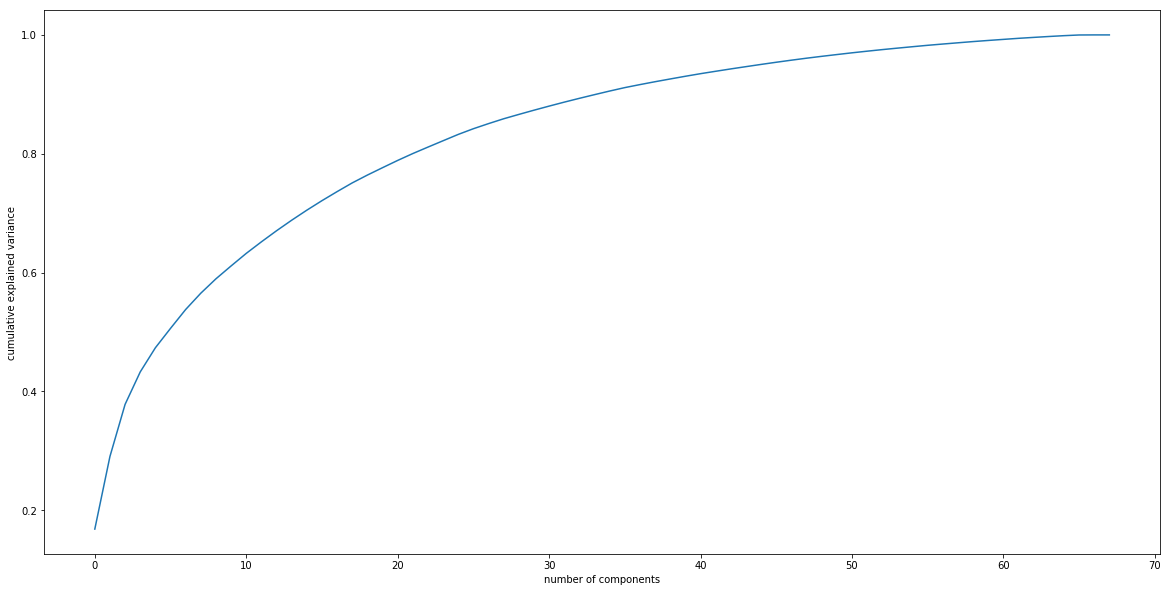

In [40]:
# check out the plot of components-to-variance and decide how many components to keep
pca = PCA().fit(scaled_data)
plt.figure(figsize= (20,10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [66]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components = 35)
pca_35 = pca.fit(scaled_data).transform(azdias_copy)

### Discussion 2.2: Perform Dimensionality Reduction

The printout of the PCA variance ratio wasn't very helpful but once the data was plotted and a visual was available, it became clear that retaining 35 components would account for about 90% of the variance in the data set. This would maximize the analysis without using an unnecessary amount of data.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [42]:
# map weights with feature names
pca_35_mapped = pd.DataFrame(pca_35.components_, columns = azdias_copy.columns)
pca_35_mapped = pca_35_mapped.T
pca_35_mapped

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
ALTERSKATEGORIE_GROB,-0.084407,0.278772,0.039851,-0.042405,0.022455,0.007919,-0.043939,0.002877,0.044534,-0.120334,...,-0.035089,0.013009,-0.040549,0.026474,0.075762,-0.006630,0.062700,-0.014773,-0.112141,-0.059021
ANREDE_KZ,0.013939,0.054438,-0.356270,0.051890,0.041331,0.061421,0.096674,-0.094045,-0.005088,0.102386,...,-0.016890,0.048708,0.003047,0.009523,-0.060971,0.000722,-0.089365,-0.068672,0.033251,0.021146
FINANZ_MINIMALIST,-0.199222,0.108025,0.132315,0.053434,0.000681,-0.125222,-0.067446,0.104266,0.022599,0.018943,...,-0.021019,-0.160252,-0.174640,-0.090303,-0.040662,0.086308,-0.153663,0.091289,0.116585,0.085680
FINANZ_SPARER,0.114087,-0.266769,-0.083029,0.000759,-0.008608,-0.003233,-0.018227,0.038729,-0.007137,-0.165697,...,0.013555,0.047199,0.084706,0.019053,0.032027,0.017943,-0.000442,0.033879,-0.018848,0.042084
FINANZ_VORSORGER,-0.084799,0.257840,0.061466,-0.024073,-0.036900,0.004059,-0.089568,0.025125,0.018158,0.195974,...,-0.035747,-0.089383,0.049367,0.061761,-0.025641,-0.119192,0.146189,-0.167359,-0.013429,-0.033056
FINANZ_ANLEGER,0.045811,-0.231244,-0.178401,-0.088756,0.056558,-0.032837,-0.061292,0.087907,0.025784,-0.130591,...,0.135049,-0.050854,0.113990,-0.050498,-0.019444,-0.049593,0.005135,-0.038792,-0.048001,0.039004
FINANZ_UNAUFFAELLIGER,0.050708,-0.241171,-0.099832,0.048808,-0.111968,-0.077483,-0.100026,0.137183,0.061330,-0.163286,...,-0.032367,0.040577,0.158902,0.059087,0.030375,0.075385,-0.033796,0.059512,-0.073201,-0.119855
FINANZ_HAUSBAUER,0.163329,0.093245,-0.051813,-0.098160,-0.009065,0.097861,0.068817,-0.104843,0.071596,0.165484,...,0.049464,0.067971,0.243885,0.080023,0.012209,-0.160594,0.237305,-0.167321,-0.195455,-0.244278
GREEN_AVANTGARDE,-0.104954,0.015208,0.068592,0.348875,-0.108516,-0.039065,0.135803,-0.026346,-0.019532,-0.058046,...,0.036402,-0.075594,-0.017459,-0.031588,0.056350,-0.016821,0.068157,-0.058081,-0.016906,-0.035455
HEALTH_TYP,0.021206,-0.059983,-0.005411,0.009810,0.007550,-0.001742,0.022517,0.002629,-0.249320,-0.262890,...,-0.142453,0.067489,0.442845,0.037246,0.032954,-0.040867,0.157130,-0.079004,0.022883,-0.064127


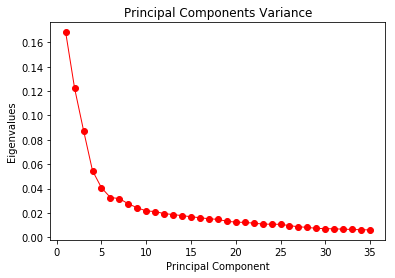

In [43]:
# plot weight distribution and look for elbow
eigenvalues = np.arange(pca.n_components_) + 1
plt.plot(eigenvalues, pca.explained_variance_ratio_, 'o-', linewidth=1, color='red')
plt.title('Principal Components Variance')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalues')
plt.show()



In [44]:
# sort features according to weight for PC 1
pca_35_sorted = pca_35_mapped.sort_values(by=0)
pca_35_sorted

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
MOBI_REGIO,-0.239293,-0.057117,-0.023549,0.054522,-0.027268,-0.167535,0.016462,-0.014920,-0.029320,0.008066,...,0.023215,0.094259,0.035521,0.047840,0.049832,-0.057726,0.057154,-0.033979,-0.070280,0.015570
PLZ8_ANTG1,-0.227861,-0.057807,-0.030777,-0.053312,-0.051058,0.016340,0.066169,0.013537,-0.186449,0.126792,...,0.058335,0.016873,0.001020,0.002408,-0.070184,0.072017,0.017743,0.004426,-0.003930,-0.008045
KBA05_ANTG1,-0.219851,-0.039501,-0.005173,0.085395,-0.028039,-0.111557,0.067077,0.037755,-0.120954,0.050418,...,0.032503,0.181139,0.018700,-0.011046,0.028445,-0.021442,0.093544,-0.027329,-0.022654,0.021732
KBA05_GBZ,-0.214484,-0.056136,-0.015361,0.041833,-0.036376,-0.180806,0.024735,-0.091944,0.007742,-0.009295,...,0.015485,0.112706,0.029929,0.103949,0.128165,-0.055771,0.076635,-0.105858,-0.145448,0.066346
FINANZ_MINIMALIST,-0.199222,0.108025,0.132315,0.053434,0.000681,-0.125222,-0.067446,0.104266,0.022599,0.018943,...,-0.021019,-0.160252,-0.174640,-0.090303,-0.040662,0.086308,-0.153663,0.091289,0.116585,0.085680
PLZ8_GBZ,-0.169966,-0.045250,-0.023965,-0.002297,-0.252129,0.273282,-0.164809,-0.130612,-0.187771,0.070309,...,-0.034384,0.025960,0.002544,-0.102399,-0.032059,-0.019058,-0.005748,0.037710,0.000992,-0.026897
KONSUMNAEHE,-0.168008,-0.049368,-0.031249,-0.120263,0.096413,-0.082818,0.049657,-0.004259,-0.098542,0.054382,...,-0.155714,-0.065690,-0.004333,0.344844,0.324653,-0.483477,-0.293263,0.289503,0.061580,-0.150942
INNENSTADT,-0.164325,-0.059980,-0.046846,-0.206020,0.010433,0.055847,-0.030426,-0.009907,0.166792,-0.062702,...,0.100128,0.101084,-0.065967,0.016125,0.094159,-0.062848,-0.056171,-0.144812,0.142775,0.059246
LP_LEBENSPHASE_FEIN,-0.144123,-0.019058,0.014401,0.220694,0.332914,0.115813,-0.219353,0.038635,0.107022,0.073774,...,0.015684,0.002045,0.135974,-0.047311,0.130335,0.146869,-0.108664,0.029230,0.008086,0.008196
LP_LEBENSPHASE_GROB,-0.130776,-0.025238,0.018381,0.218435,0.352146,0.135244,-0.212835,0.020389,0.094976,0.073228,...,0.013727,0.020313,0.143864,-0.048377,0.139349,0.171542,-0.123995,0.068654,0.000861,0.019370


In [45]:
def map_weights(pca,PC):
    # correlate feature names to weights, flip orientation
    pca_35_mapped = pd.DataFrame(pca_35.components_, columns = azdias_copy.columns)
    pca_35_mapped = pca_35_mapped.T
    
    # sort weights for selected PC
    #pca_35_sorted = pca_35_mapped.sort_values(by=PC)
    pca_35_sorted = (pca_35_mapped.sort_values(by=PC))[PC]
    
    return pca_35_sorted


In [46]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print(map_weights(pca_35,0))

MOBI_REGIO              -0.239293
PLZ8_ANTG1              -0.227861
KBA05_ANTG1             -0.219851
KBA05_GBZ               -0.214484
FINANZ_MINIMALIST       -0.199222
PLZ8_GBZ                -0.169966
KONSUMNAEHE             -0.168008
INNENSTADT              -0.164325
LP_LEBENSPHASE_FEIN     -0.144123
LP_LEBENSPHASE_GROB     -0.130776
BALLRAUM                -0.124985
C_I_2015_LIFESTAGE      -0.117312
GEBAEUDETYP_RASTER      -0.116070
GREEN_AVANTGARDE        -0.104954
ANZ_PERSONEN            -0.097109
WOHNLAGE                -0.089403
FINANZ_VORSORGER        -0.084799
ALTERSKATEGORIE_GROB    -0.084407
KBA13_ANZAHL_PKW        -0.080402
ONLINE_AFFINITAET       -0.065853
MIN_GEBAEUDEJAHR        -0.052734
SEMIO_ERL               -0.052013
OST_WEST_KZ             -0.050613
WOHNDAUER_2008          -0.048510
SEMIO_VERT              -0.048134
SEMIO_LUST              -0.046025
ANZ_TITEL               -0.003582
SOHO_KZ                 -0.002859
RETOURTYP_BK_S          -0.000219
KBA05_ANTG2   

In [47]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print(map_weights(pca_35,1))

P_J_DECADE              -0.267326
FINANZ_SPARER           -0.266769
SEMIO_REL               -0.258377
SEMIO_PFLICHT           -0.252166
FINANZ_UNAUFFAELLIGER   -0.241171
SEMIO_TRADV             -0.240746
FINANZ_ANLEGER          -0.231244
SEMIO_RAT               -0.201468
SEMIO_KULT              -0.194702
SEMIO_FAM               -0.179480
SEMIO_MAT               -0.174065
ONLINE_AFFINITAET       -0.155062
SEMIO_SOZ               -0.064126
HEALTH_TYP              -0.059983
INNENSTADT              -0.059980
PLZ8_ANTG1              -0.057807
MOBI_REGIO              -0.057117
KBA05_GBZ               -0.056136
BALLRAUM                -0.053093
KONSUMNAEHE             -0.049368
PLZ8_GBZ                -0.045250
ANZ_PERSONEN            -0.041801
KBA05_ANTG1             -0.039501
MIN_GEBAEUDEJAHR        -0.036555
GEBAEUDETYP_RASTER      -0.036177
WOHNLAGE                -0.035060
OST_WEST_KZ             -0.027964
LP_LEBENSPHASE_GROB     -0.025238
KBA13_ANZAHL_PKW        -0.023772
LP_LEBENSPHASE

In [48]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print(map_weights(pca_35,2))

SEMIO_KAEM              -0.356375
ANREDE_KZ               -0.356270
SEMIO_DOM               -0.328757
SEMIO_KRIT              -0.309433
FINANZ_ANLEGER          -0.178401
SEMIO_ERL               -0.178021
SEMIO_RAT               -0.177293
FINANZ_UNAUFFAELLIGER   -0.099832
FINANZ_SPARER           -0.083029
P_J_MOVEMENT            -0.068592
FINANZ_HAUSBAUER        -0.051813
SEMIO_PFLICHT           -0.048235
INNENSTADT              -0.046846
P_J_DECADE              -0.046471
BALLRAUM                -0.045622
VERS_TYP                -0.042005
GEBAEUDETYP_RASTER      -0.039257
OST_WEST_KZ             -0.035036
KONSUMNAEHE             -0.031249
PLZ8_ANTG1              -0.030777
KKK                     -0.027329
PLZ8_GBZ                -0.023965
MOBI_REGIO              -0.023549
REGIOTYP                -0.020252
SEMIO_TRADV             -0.018534
KBA13_ANZAHL_PKW        -0.015709
KBA05_GBZ               -0.015361
PLZ8_HHZ                -0.011389
ONLINE_AFFINITAET       -0.008776
HEALTH_TYP    

### Discussion 2.3: Interpret Principal Components

PC1 shows a high positive correlation between single and duplex housing in region and microcell. It also shows a high positive correlation between medium and high density housing in a region. There is a high negative correlation between low and high density housing in a region. This makes intuitive sense, as neighborhoods tend to be full of houses or apartment buildings, but not both.

PC2 shows a high positive correlation between more reliable personality and financial types, and a high positive correlation between event-oriented personality type and financial type-be prepared. I'm not quite sure how to interpret this second positive correlation; it may be significant or not. The high negative correlation between reliable/stable personality types and sensual personality type does seem significant, in that it could be expected that these two personality types are quite opposite each other.

PC3 shows high positive correlation between less agreeable personality traits and gender, as well as high positive correlation between more agreeable personality types. There is a high negative correlation between less agreeable and more agreeable personality traits, which is a reasonable assumption.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [82]:
from sklearn.cluster import MiniBatchKMeans

In [101]:
# Over a number of different cluster counts...
data = scaled_data
clusters = [2,4,6,8,10,12,14,16,18,20]
scores = []

for num in clusters:
    kmeans = MiniBatchKMeans(num)
    model = kmeans.fit(data)
    scores.append(abs(model.score(data)))

print(scores)    

[53576710.496113934, 47441658.9284916, 44708897.571440294, 42870000.952162504, 41166729.63102106, 38950621.756797366, 39788578.160976253, 38753668.49653402, 37438117.427372351, 36023955.711928904]


Text(0,0.5,'Average Distance from Centroid')

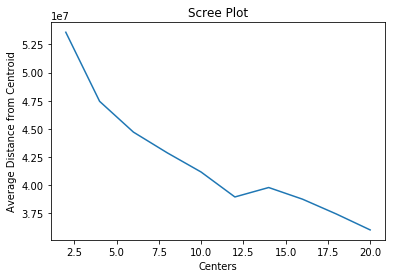

In [102]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
centers = list(clusters)
plt.plot(centers, scores)
plt.title('Scree Plot')
plt.xlabel('Number of Centers')
plt.ylabel('Average Distance from Centroid')     

In [110]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans_final = MiniBatchKMeans(12)
model_final = kmeans_final.fit(data)


labels_final = model_final.predict(data)
print(labels_final)

[5 8 2 ..., 1 0 7]


### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [ ]:
# Load in the customer demographics data.
customers = 

In [ ]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.



### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [ ]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.



In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?



In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?



### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.